# <span style = "color:Black"> **Recap & Goal**

- 궁극적인 목적은 20개의 클래스를 가지는 픽토그램 데이터를 잘 분류하는 것입니다.
- 하지만 데이터 안에 이상치(실제사진)가 있는 몇 개의 클래스가 있었습니다.
- 이는 분류모형의 학습에 악영향을 끼칠 수 있습니다.
- 따라서 여기서는 이상치를 제거하는 모형을 먼저 만들고 이상치를 제거합니다.

______________________________________________

# <span style = "color:Black"> **Import & Setup**

In [1]:
import random
import os, sys
from albumentations import *
pckg_path = "C:/Users/22668/Desktop/github/sin-hoyeon/posts"
sys.path.append(pckg_path)

from creatorcamp.code.setup import *

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import torch
import seaborn as sns
import torchvision
from torchvision import transforms
from torchvision.transforms import *
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score,recall_score
from torchvision.datasets import *
%matplotlib inline

In [2]:
all_data=get_ts_data(path=inform['path'])
print(f'Dataset의 크기 : {len(all_data)}')
print(f'Dataset에 존재하는 클래스의 갯수 : {len(all_data.classes)}')
print(f'setup \n{inform}')

Dataset의 크기 : 25503
Dataset에 존재하는 클래스의 갯수 : 20
setup 
{'name': 'hoyeon', 'path': 'C:/Users/22668/Desktop/github/sin-hoyeon/posts/creatorcamp/dataset'}


# <span style = "color:Black"> **Working**

## <span style = "color:Black"> 첫번째 모형


- EDA에서 픽토그램의 경우 픽셀값을 확인해본 결과 모든 채널에서 1주변으로 값이 몰려있고 실제사진의 경우 1주변에 몰려있지 않고 값이 골고루 퍼져서 존재함을 확인했습니다.
- 이는 다음을 암시합니다.

::: {.callout-note icon=false}
## 가정
- 픽토그램이라면 3개의 채널에서 모두 1주변의 확률값이 어떤 `기준값`을 넘을 것이다.
- 픽토그램이 아닌 실제사진이라면 3개의 채널 중 적어도 하나는 확률값이 어떤 `기준값`을 넘지 않을 것이다.
:::

- 상기의 가정을 통해서 기준값을 통해 이상치를 찾는 코드를 구현해보면 아래와 같습니다.

In [3]:
#| echo: true

def ck_outlier(img,
               threshold,          #확률밀도함수의 기준값
               sampling_num = 30): #Kde에서 sampling할 갯 수.

  #Kde추정하는 객체 만들기
  X = torch.linspace(0.5,1.1,sampling_num)
  
  #검은색 배경을 가진 추상이미지는 별로 없고 실제사진이 검은색이므로 확률분포에서 0.5이상인 부분만 보면 됨!
  estr_0 = stats.gaussian_kde(img[0].reshape(-1), bw_method='silverman')
  estr_1 = stats.gaussian_kde(img[1].reshape(-1), bw_method='silverman')
  estr_2 = stats.gaussian_kde(img[2].reshape(-1), bw_method='silverman')

  #확률밀도함수의 y값 구해보기
  r_max = np.max(estr_0(X))
  g_max = np.max(estr_1(X))
  b_max = np.max(estr_2(X))
  #가정,R,G,B값 중 3개 모두 확률밀도의 최댓값이 threshold이상이면 픽토그램.
  count=0
  if r_max>threshold:
    count+=1
  if g_max>threshold:
    count+=1
  if b_max>threshold:
    count+=1
  if count >=3:
    return False #추상이미지는 아웃라이어 아니므로 False
  else:
    return True 

### <span style = "color:Black"> 기준값 찾기
- 가정에 의하면 픽토그램과 이상치(실제사진)을 구분하는 `기준값`이 존재하므로 이를 찾는다면 픽토그램에서 실제사진을 제거할 수 있습니다.
- 따라서 전체데이터에서 이미지를 몇개 샘플링하여 픽토그램과 이상치를 구분하는 `기준값`을 찾습니다.

### <span style = "color:Black"> 1. 이미지 샘플링하여 데이터 만들기

- 이미지를 샘플링 한 후 직접 레이블링 한 코드입니다.

In [ ]:
#| echo: true
#1. 기준값을 찾기위해서 사용할 이미지들 임의적으로 추출
tmp = []
except_class = [1,5,8,14,19]
for i in range(0,20):
  if i not in except_class:
    class_imgs=get_class_image(all_data,class_num=i,sampling=20)
  else:
    class_imgs=get_class_image(all_data,class_num=i,sampling=40)
  tmp.append(class_imgs)
imgs = torch.cat(tmp)

#2. 추출한 이미지에 대하여 직접 레이블링
ch_0_label = [0] * 20
ch_1_label = [True,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1]
ch_2_label = [0] * 20
ch_3_label = [0] * 20
ch_4_label = [0] * 20
ch_5_label = [False,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,True,False,True,True]+[0,1,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0]
ch_6_label = [0] * 20
ch_7_label = [0] * 20
ch_8_label = [False,True,True,True,True,True,True,True,True,True,True,True,False,True,False,False,True,False,True,True]+[0,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0,1,1]
ch_9_label = [0] * 20
ch_10_label = [0] * 20
ch_11_label = [0] * 20
ch_12_label = [0] * 20
ch_13_label = [0] * 20
ch_14_label = [False,True,True,True,True,True,True,False,False,True,True,False,False,True,True,False,True,True,True,False]+[1,0,1,0,0,0,1,0,1,0,0,0,1,1,1,1,1,1,1,0]
ch_15_label = [0] * 20
ch_16_label = [0] * 20
ch_17_label = [0] * 20
ch_18_label = [False,False,True,True,True,True,True,False,False,True,False,False,False,False,True,False,True,True,True,False]+[0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1]
ch_19_label = [0] * 20
y_true=pd.DataFrame({'y_true':ch_0_label + ch_1_label + ch_2_label + ch_3_label + ch_4_label + ch_5_label + ch_6_label + ch_7_label\
                    +ch_8_label + ch_9_label + ch_10_label + ch_11_label + ch_12_label + ch_13_label + ch_14_label + ch_15_label\
                    +ch_16_label + ch_17_label + ch_18_label + ch_19_label})
y_true=y_true['y_true'].map({False:0,True:1,0:0,1:1})
y_true=y_true.values.reshape(-1,1)

샘플링된 이미지에서 픽토그램은 379개 실제사진은 121개 존재합니다.


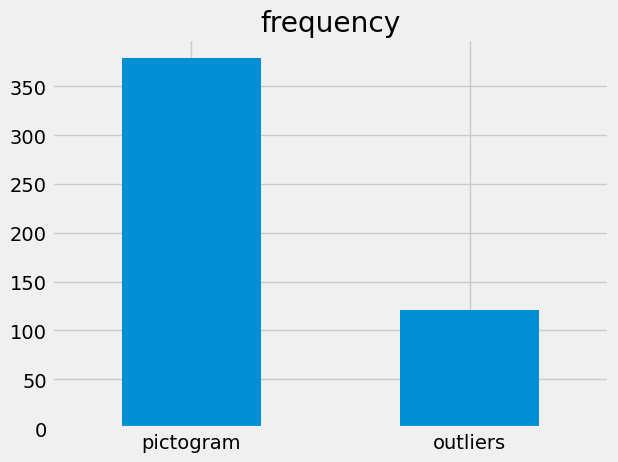

In [ ]:
num_images = pd.Series(y_true.reshape(-1)).value_counts()
num_images.plot(kind="bar",title="frequency")
plt.xticks([0,1],["pictogram","outliers"])
plt.xticks(rotation=0)
print(f'샘플링된 이미지에서 픽토그램은 {num_images[0]}개 실제사진은 {num_images[1]}개 존재합니다.')

### <span style = "color:Black"> 2. 기준값 비교하기

- 기준값을 찾기 위해서는 어떤 값을 써야할까요?
- 기준값의 목적은 픽토그램과 이상치를 분류하는 것이므로 분류성능이 좋아야 할 것 입니다.
- 따라서 여기서는 `f1-score`가 좋은 기준값을 최종적인 선택을 위한 먼저 후보로 두었습니다.

::: {.callout-note icon=false appearance=simple}
# 기준 1
- 전반적인 모형의 성능이 준수해야 한다.
:::

- 다만 이렇게 해도 여기서 f1-score가 비슷하게 나오는 기준값은 여러가지 입니다.
- 그러므로 그 중에서도 가장 좋은 `기준값`을 선정해야할 것입니다.
- 모델의 특성상 이러한 기준값들은 다음과 같은 특징을 지닙니다.
    1. mission3에 사용할 훈련데이터를 비교적 많이 삭제하나 이상치도 많이 삭제하는 모델
    2. mission3에 사용할 훈련데이터를 비교적 덜 삭제하나 이상치도 덜 삭제하는 모델
- 저는 훈련데이터의 양은 어느정도 충분하기에 이상치를 많이 삭제하는 모형이 더 좋다고 판단했습니다.
- 왜냐하면 이상치가 나중에 분류모형에 미칠 악영향이 훨씬 더 클 것이기 때문입니다.
- 따라서 최종후보들중에서 `recall`이 높은 가장 높게 나오는 기준값을 선택하겠습니다.

::: {.callout-note icon=false appearance=simple}
# 기준 2
- 모델의 성능이 어느정도 비슷하다면 최대한 이상치를 많이 삭제해야한다.
:::

In [ ]:
threshold=np.linspace(2,10,80)
pred_y = predict_outlier(imgs,threshold)

In [ ]:
f1_sc=[]
recall_sc = []
for pred in pred_y:
  f1_sc.append(f1_score(y_true,pred))
  recall_sc.append(recall_score(y_true,pred))


df=pd.DataFrame({'th':threshold,'f1_sc':f1_sc})
df.to_csv(inform["path"]+"/df1.csv")

df=pd.DataFrame({'th':threshold,'recall_sc':recall_sc})
df.to_csv(inform["path"]+"/df2.csv")

f1_score = pd.read_csv(inform["path"]+"/df1.csv")
f1_score=f1_score.drop(columns = "Unnamed: 0")
recall_score = pd.read_csv(inform["path"]+"/df2.csv")
recall_score=recall_score.drop(columns = "Unnamed: 0")


#### Top3 f1-score

- 가장 `f1-score`가 뛰어난 기준값들은 아래와 같습니다.

In [ ]:
f1_score.iloc[12:15,:]

th     f1_sc
12  3.215190  0.917749
13  3.316456  0.910638
14  3.417722  0.915254

#### Top3 recall

- 이들 각각의 기준값에 대한 `recall`은 아래와 같습니다.

In [ ]:
recall_score.iloc[12:15,:]

th  recall_sc
12  3.215190   0.876033
13  3.316456   0.884298
14  3.417722   0.892562

#### Confusion Matrix

In [ ]:
threshold = f1_score.iloc[12:15,].th

In [ ]:
pred_1 = predict_outlier(imgs,threshold[12])
pred_2 = predict_outlier(imgs,threshold[13])
pred_3 = predict_outlier(imgs,threshold[14])

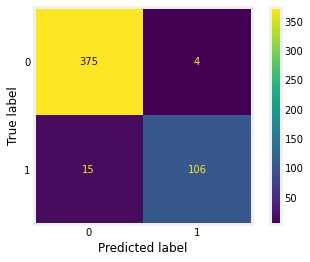

In [ ]:
cm=confusion_matrix(y_true,pred_1)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.grid(False)

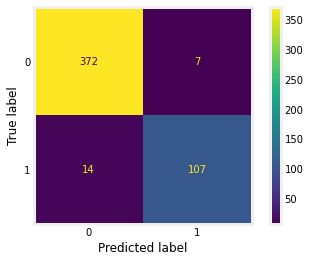

In [ ]:
cm=confusion_matrix(y_true,pred_2)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.grid(False)

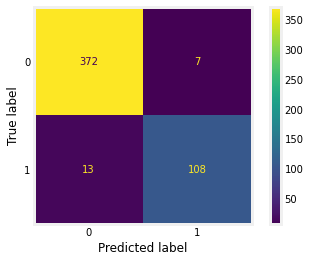

In [ ]:
cm=confusion_matrix(y_true,pred_3)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.grid(False)

### <span style = "color:Black"> 3. 모형 결정하기

- 최종적으로 Top3 f1-score를 기록하는 예측모형 중 `threshold = 3.417722` 인 모형을 선택했습니다.
- 기준1,2를 동시에 만족하여 높은 성능과 가능한 많은 이상치의 제거를 보장하기 때문입니다.

In [ ]:
k = 3.417722
#print(f'선택한 기준k는 {k}입니다.')

### <span style = "color:Black"> 4. 모형의 성능확인

- 새로운 데이터셋을 추가적으로 구성하여 모형의 성능을 간단히 확인해보았습니다.

#### <span style = "color:Black"> test1

In [ ]:
random.seed(50)
idx=[idx for idx in range(len(all_data))]
rd_idx=random.sample(idx,20)

imgs=[]
for img_idx in rd_idx:
  imgs.append(all_data[img_idx][0])
imgs=torch.stack(imgs)

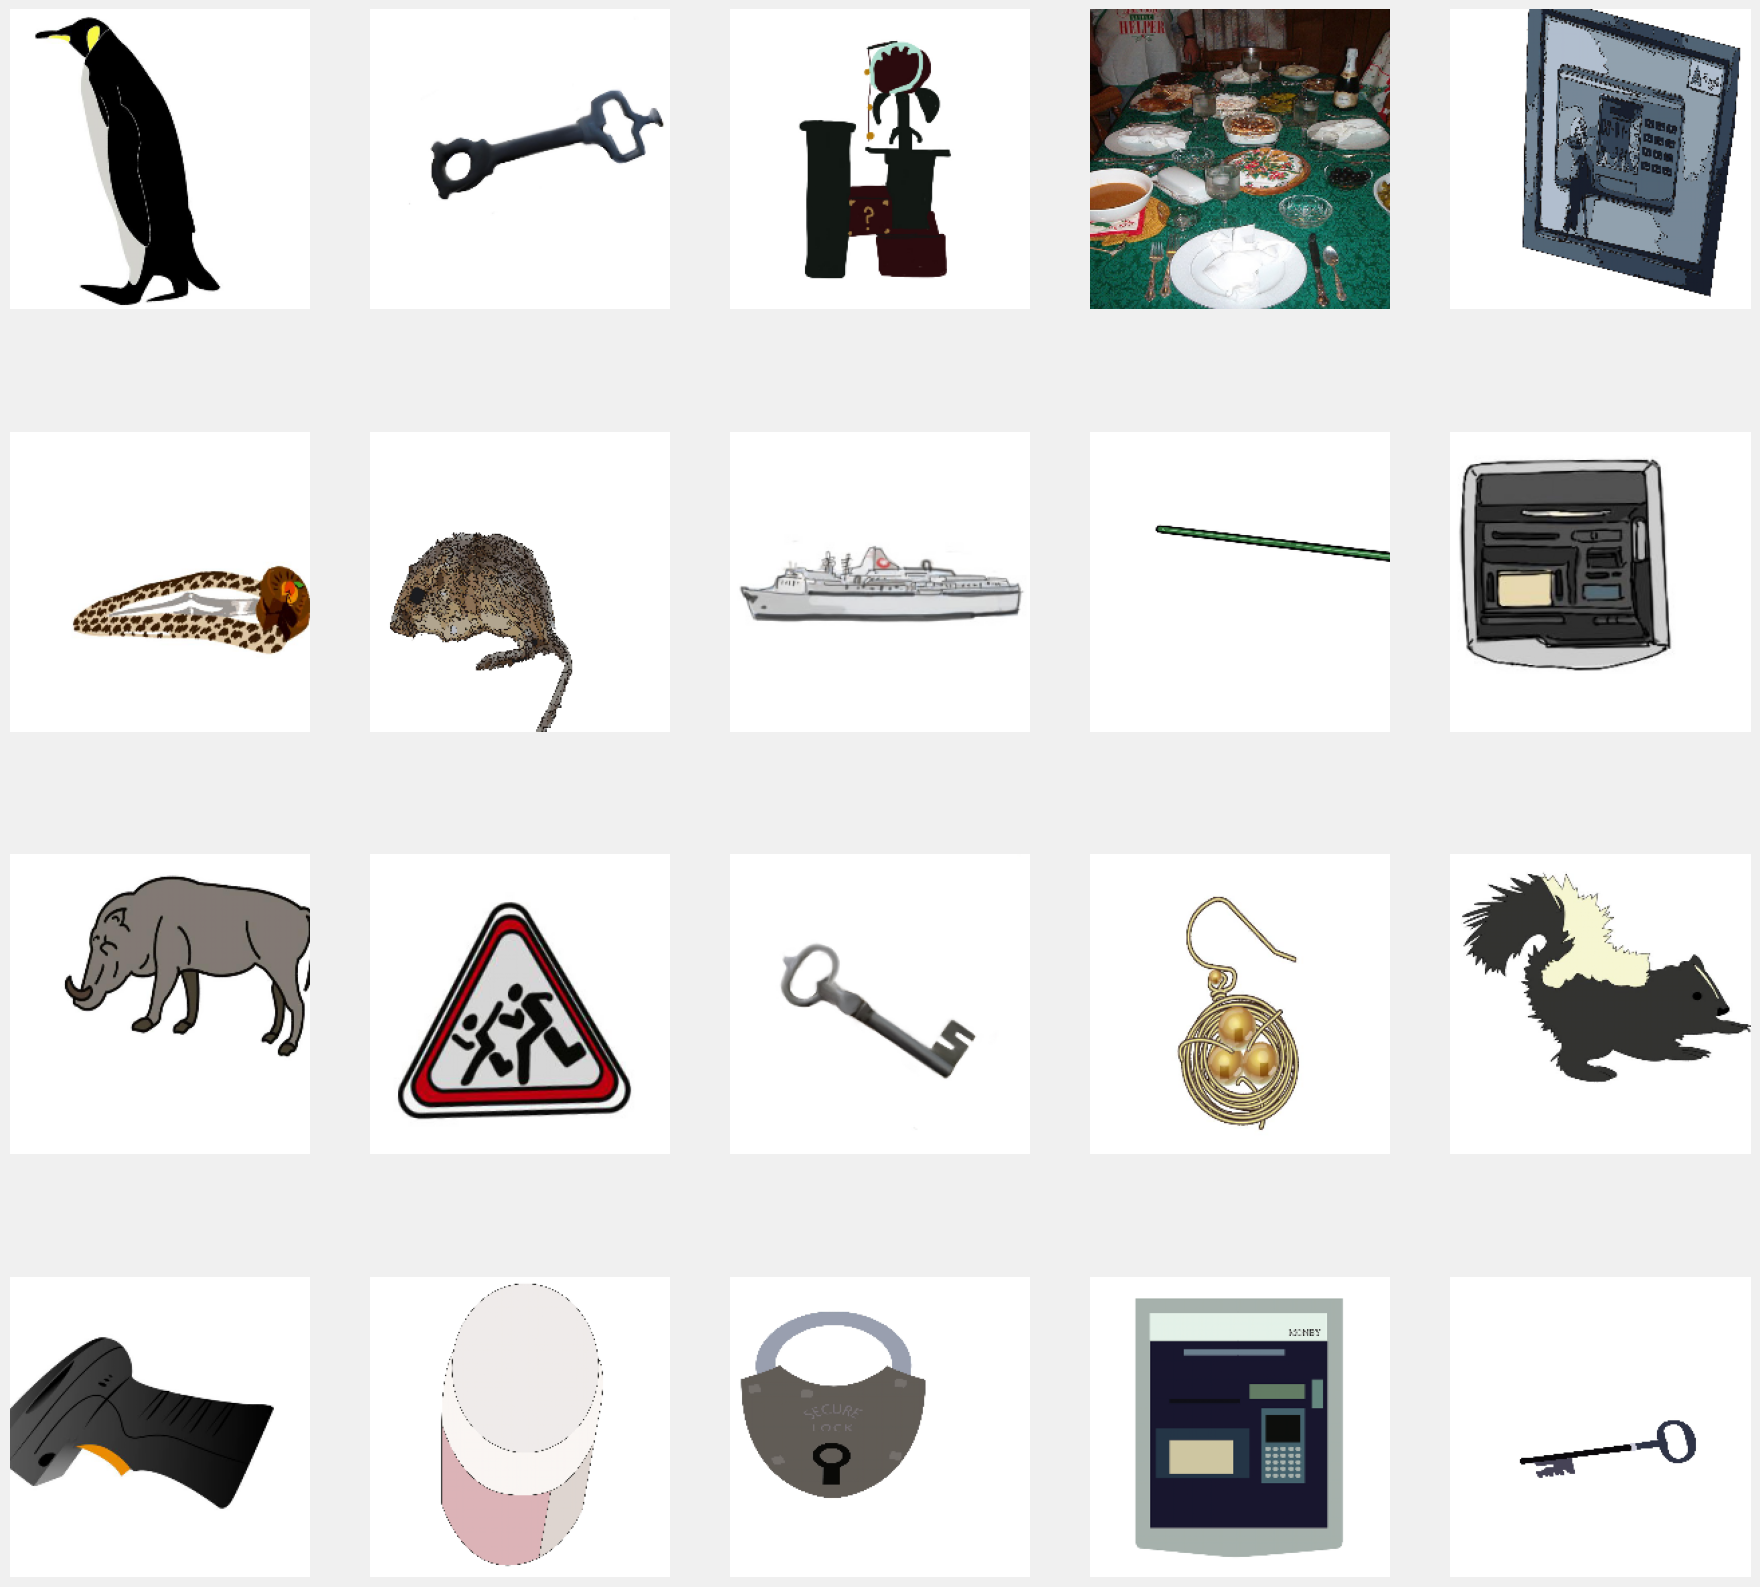

In [ ]:
show_images(imgs)

In [ ]:
true_y = [False] * 19
true_y.insert(3,True)
pred_y = predict_outlier(imgs,threshold=k)

pred_y=pred_y.reshape(-1)
true_y=np.array(true_y)
true_y.shape,pred_y.shape
false_idx=[]
for idx in range(len(true_y)):
  if (true_y==pred_y)[idx]==False:
    false_idx.append(idx)

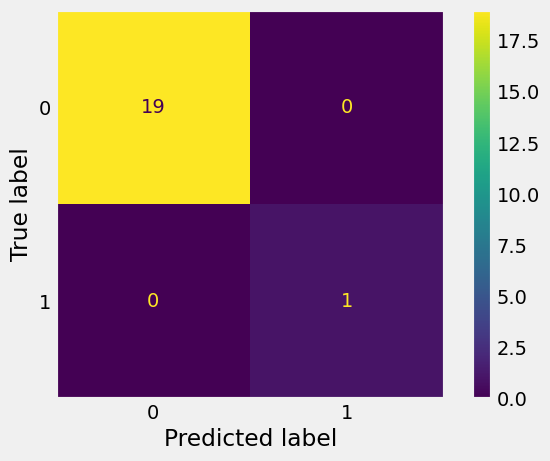

In [ ]:
cm=confusion_matrix(true_y,pred_y)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.grid(False)

#### <span style = "color:Black"> test2

In [ ]:
random.seed(60)
idx=[idx for idx in range(len(all_data))]
rd_idx=random.sample(idx,20)

imgs=[]
for img_idx in rd_idx:
  imgs.append(all_data[img_idx][0])
imgs=torch.stack(imgs)

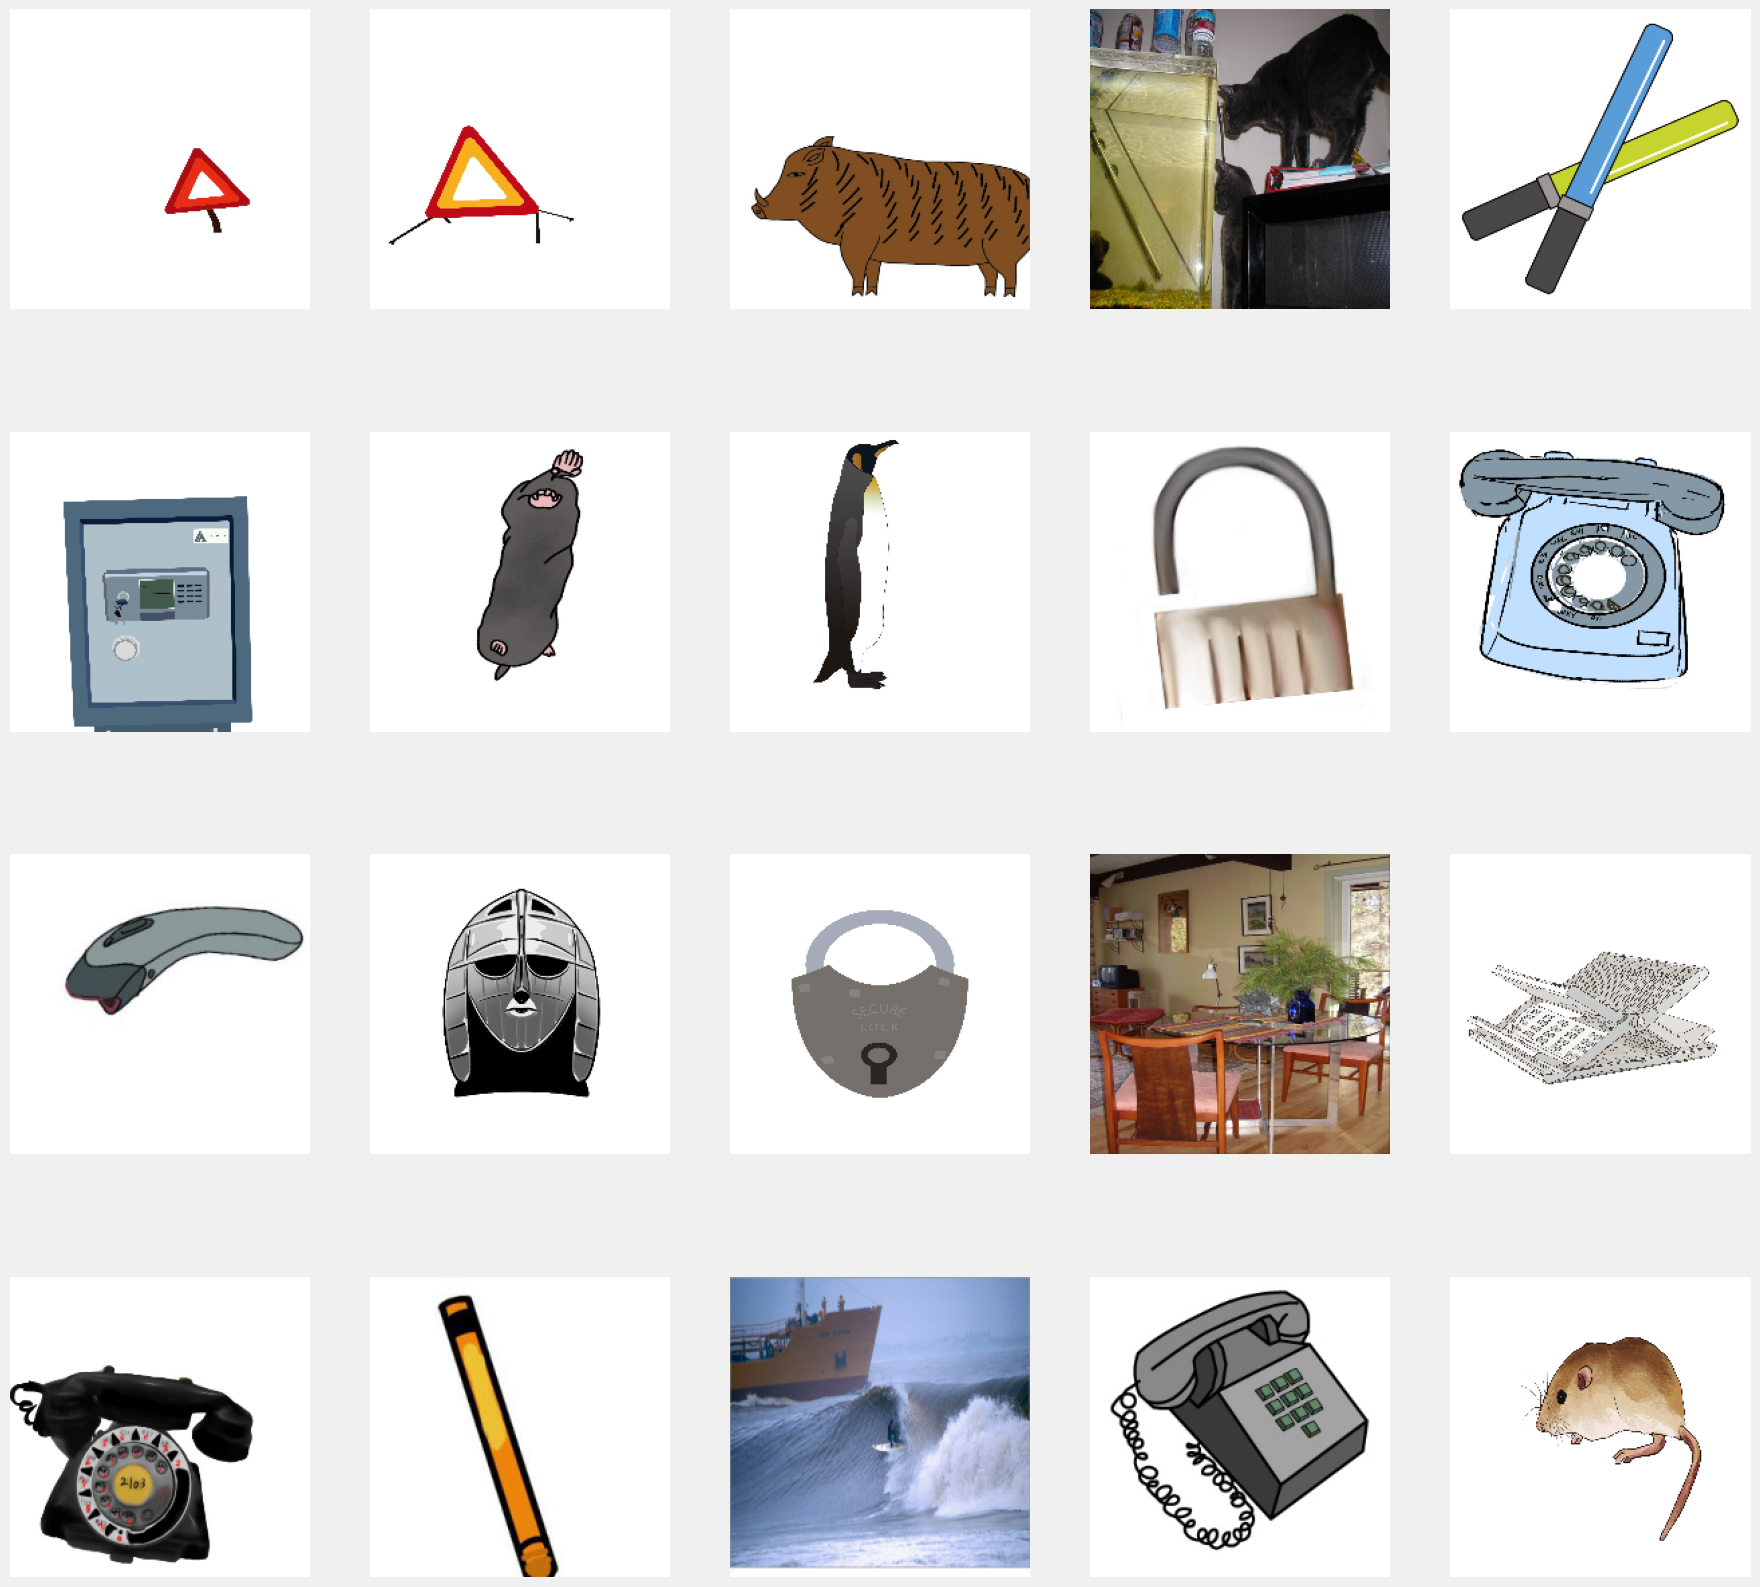

In [ ]:
show_images(imgs)

In [ ]:
true_y = [0] * 17
true_y.insert(3,1)
true_y.insert(13,1)
true_y.insert(17,1)
pred_y = predict_outlier(imgs,threshold=k)

pred_y=pred_y.reshape(-1)
true_y=np.array(true_y)
true_y.shape,pred_y.shape
false_idx=[]
for idx in range(len(true_y)):
  if (true_y==pred_y)[idx]==False:
    false_idx.append(idx)

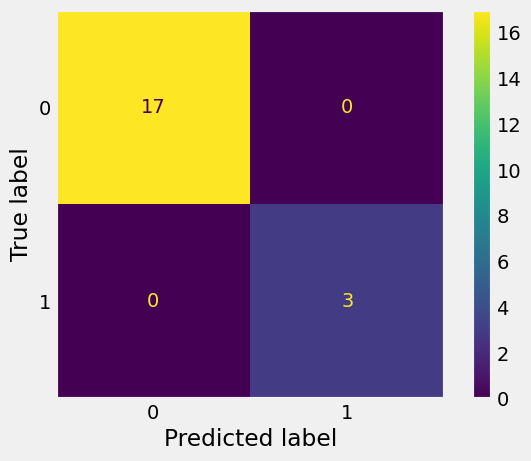

In [ ]:
cm=confusion_matrix(true_y,pred_y)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.grid(False)

- 각각 20개의 이미지를 가지는 서로다른 test data를 구성하여 모델의 성능을 확인해보았습니다.
- 총 40개 중 1개의 이미지에 대해서만 오분류했습니다.
- 성능이 꽤 좋음을 알 수 있습니다.

### <span style = "color:Black"> 5. 전체데이터에서 이상치 찾기

- 만들어진 첫번째 모형을 전체데이터에 적용합니다.
- 결과는 아래와 같습니다.

In [15]:
p1=int((1/3) * len(all_data))
p2=int((2/3) * len(all_data))
k = 3.417722

In [ ]:
# 실제사진과 추상이미지가 섞여있는 클래스만 대상으로 했음.  
# 근데 실제 코드제출용에서는 모든 클래스를 대상으로 해야할듯함.

"""
outlier_predict1=[]
ck_list=[5,8,18,14,1]

for idx in range(p1):
  if idx % 500 == 0:
    print(f'{idx} ....')
  try:
    if all_data.targets[idx] not in ck_list: #ck_list에 있는 클래스가 아닌경우,이상치가 존재하지 않는 클래스들이므로 모두 0을 반환
      outlier_predict1.append(0)
      continue
    if ck_outlier(all_data[idx][0],k)==False:
      outlier_predict1.append(0)
    else:
      outlier_predict1.append(1)
  except: #오류가 날 경우 0으로 반환
    outlier_predict1.append(0)
"""

In [ ]:
"""
df=pd.DataFrame({'predict':outlier_predict1})
df.to_csv('/content/drive/MyDrive/anmly_dtcion_rst1.csv')
"""

"""
outlier_predict2=[]
ck_list=[5,8,18,14,1]

for idx in range(p1,p2):
  if idx % 500 == 0:
    print(f'{idx} ....')
  try:
    if all_data.targets[idx] not in ck_list: #ck_list에 있는 클래스가 아닌경우,이상치가 존재하지 않는 클래스들이므로 모두 0을 반환
      outlier_predict2.append(0)
      continue
    if ck_outlier(all_data[idx][0],k)==False:
      outlier_predict2.append(0)
    else:
      outlier_predict2.append(1)
  except: #오류가 날 경우 0으로 반환
    outlier_predict2.append(0)
"""
"""
df=pd.DataFrame({'predict':outlier_predict2})
df.to_csv('/content/drive/MyDrive/anmly_dtcion_rst2.csv')
"""

In [ ]:
#역행렬이 구해지지 않아서 오류코드가 
#21945번째 이미지 에러
#예외처리문으로 수정한 이유
"""
outlier_predict3=[]
ck_list=[5,8,18,14,1]

for idx in range(p2,len(all_data)):
  if idx % 500 == 0:
    print(f'{idx} ....')
  try:
    if all_data.targets[idx] not in ck_list: #ck_list에 있는 클래스가 아닌경우,이상치가 존재하지 않는 클래스들이므로 모두 0을 반환
      outlier_predict3.append(0)
      continue
    if ck_outlier(all_data[idx][0],k)==False:
      outlier_predict3.append(0)
    else:
      outlier_predict3.append(1)
  except: #오류가 날 경우 0으로 반환
    outlier_predict3.append(0)
    error_idx.append(idx)
"""

"""
df=pd.DataFrame({'predict':outlier_predict3})
df.to_csv('/content/drive/MyDrive/anmly_dtcion_rst3.csv')
"""

In [ ]:
"""
#데이터프레임 만들기 - 
#ck_list=[5,8,18,14,1]인 클래스에서만 이상치 검사
df_1=pd.read_csv('/content/drive/MyDrive/anmly_dtcion_rst1.csv')
df_2=pd.read_csv('/content/drive/MyDrive/anmly_dtcion_rst2.csv')
df_3=pd.read_csv('/content/drive/MyDrive/anmly_dtcion_rst3.csv')

df=pd.concat([df_1,df_2,df_3])
df=df.reset_index(drop=True)

_targets=pd.DataFrame({'category':all_data.targets})
df=pd.concat([df,_targets],axis=1)
df=df.drop(columns={'Unnamed: 0'})
df['address']=[os.path.basename(address) for address,_ in all_data.imgs]

"""

In [ ]:
#| echo: true

error_idx = []
outlier_predict1=[]

for idx in range(p1):
  if idx % 5000 == 0:
    print(f'{idx} ....')
  try:
    if ck_outlier(all_data[idx][0],k)==False:
      outlier_predict1.append(0)
    else:
      outlier_predict1.append(1)
  except: #오류가 날 경우 0으로 반환
    outlier_predict1.append(0)
    
df=pd.DataFrame({'predict':outlier_predict1})
#df.to_csv('/content/drive/MyDrive/anmly_dtcion_rst_1.csv')

path1 = inform["path"] + '/anmly_dtcion_rst_1.csv'
df=pd.DataFrame({'predict':outlier_predict1})
df.to_csv(path1)

outlier_predict2=[]
ck_list=[None]

for idx in range(p1,p2):
  if idx % 500 == 0:
    print(f'{idx} ....')
  try:
    if ck_outlier(all_data[idx][0],k)==False:
      outlier_predict2.append(0)
    else:
      outlier_predict2.append(1)
  except: #오류가 날 경우 0으로 반환
    outlier_predict2.append(0)

path2 = inform["path"] + '/anmly_dtcion_rst_2.csv'
df=pd.DataFrame({'predict':outlier_predict2})
df.to_csv(path2)

#역행렬이 구해지지 않아서 오류코드가 
#21945번째 이미지 에러
#예외처리문으로 수정한 이유
outlier_predict3=[]
ck_list=[None]

for idx in range(p2,len(all_data)):
  if idx % 500 == 0:
    print(f'{idx} ....')
  try:
    if ck_outlier(all_data[idx][0],k)==False:
      outlier_predict3.append(0)
    else:
      outlier_predict3.append(1)
  except: #오류가 날 경우 0으로 반환
    outlier_predict3.append(0)
    error_idx.append(idx)

path3 = inform["path"] + '/anmly_dtcion_rst_3.csv'
df=pd.DataFrame({'predict':outlier_predict3})
df.to_csv(path3)

In [5]:
#| echo: true

#데이터프레임 만들기 - 
#모든 클래스에서 이상치 검사

path1 = inform["path"] + '/anmly_dtcion_rst_1.csv'
path2 = inform["path"] + '/anmly_dtcion_rst_2.csv'
path3 = inform["path"] + '/anmly_dtcion_rst_3.csv'

df_1=pd.read_csv(path1)
df_2=pd.read_csv(path2)
df_3=pd.read_csv(path3)

df=pd.concat([df_1,df_2,df_3])
df=df.reset_index(drop=True)

_targets=pd.DataFrame({'category':all_data.targets})
df=pd.concat([df,_targets],axis=1)
df=df.drop(columns={'Unnamed: 0'})
df['address']=[os.path.basename(address) for address,_ in all_data.imgs]

In [73]:
#| echo: true

df=df[["address","predict","category"]]
df['address']=df['address'].str.replace('.jpg',"").str.replace('.png',"")
df.sample(10)

#내보내기 코드
#df.to_csv('/content/drive/MyDrive/anmly_dtctn_rst_newversion2.csv')

address  predict  category
9421   qqbcsppljdltwzapjtbr        0         6
4980   hwofwsgjoxkfhawplbhu        1         5
914    mqqxrlwghsnfxwgpbmch        1         0
24979  veynjbiugcwnoagiopmv        0        18
4028   glwatzhxafftqoieiimu        0         3
1980   edcmqpgaioimnqtnwjvt        0         1
8964   orrfbwghoupwfdhvyejc        0         6
7153   gxuxkfolqaedlryneobz        0         6
21250  ommrmrkfutfmqwjijcdh        0        15
17491  sjnzmrkcqvjejazxcjxl        0        10

In [9]:
print(f'데이터셋의 크기 : {len(df)}')
print(f'확률분포모델에서 이상치(실제사진)이라 판단한 이미지의 갯수 : {sum(df.predict==1)}')
print(f'확률분포모델에서 픽토그램이라 판단한 이미지의 갯수 : {len(df)-sum(df.predict==1)}')

데이터셋의 크기 : 25503
확률분포모델에서 이상치(실제사진)이라 판단한 이미지의 갯수 : 2218
확률분포모델에서 픽토그램이라 판단한 이미지의 갯수 : 23285


In [37]:
idx_to_class = {}
for cls,label in all_data.class_to_idx.items():
    idx_to_class[label] = cls

#df.groupby("category").mean().plot(kind="bar")
#plt.grid(False)

In [38]:
predict_1_df=df[df.predict==1]
#predict_1_df

In [39]:
each_class_count=[]
for cls_num in df.category.unique():
  each_class_count.append(len(predict_1_df[predict_1_df.category==cls_num]))
cls_anomaly_ratio=np.array(each_class_count)/len(predict_1_df) * 100
#cls_anomaly_ratio

- 이상치(실제사진)로 분류한 이미지를 실제로 확인해보면 아래와 같습니다. 

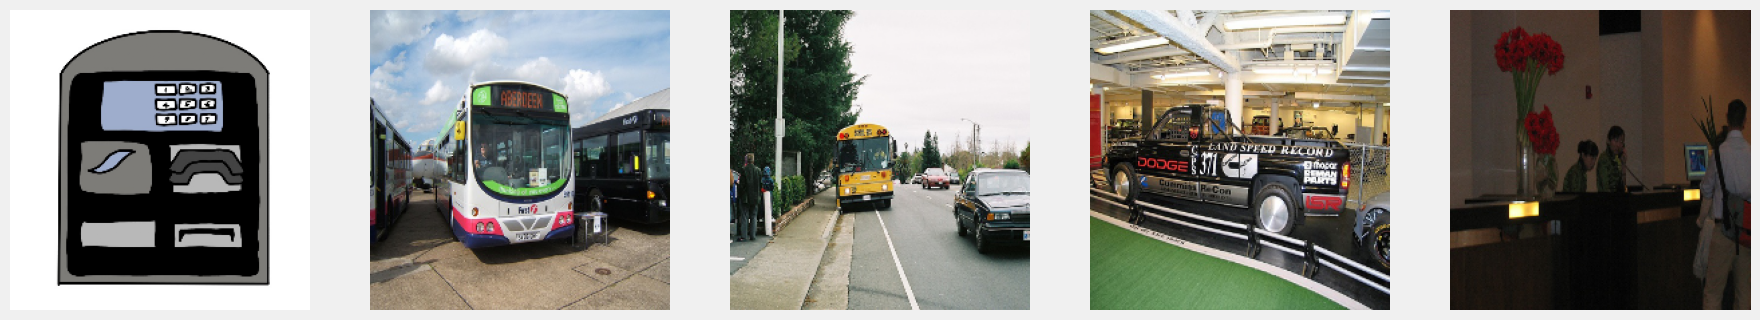

In [41]:
cls_num=1
num_images=5

anom_indices=(predict_1_df[predict_1_df.category==cls_num]).index.values[:50]
imgs=get_imgs(all_data,anom_indices)
anom_images=imgs[:num_images]
show_images(anom_images)

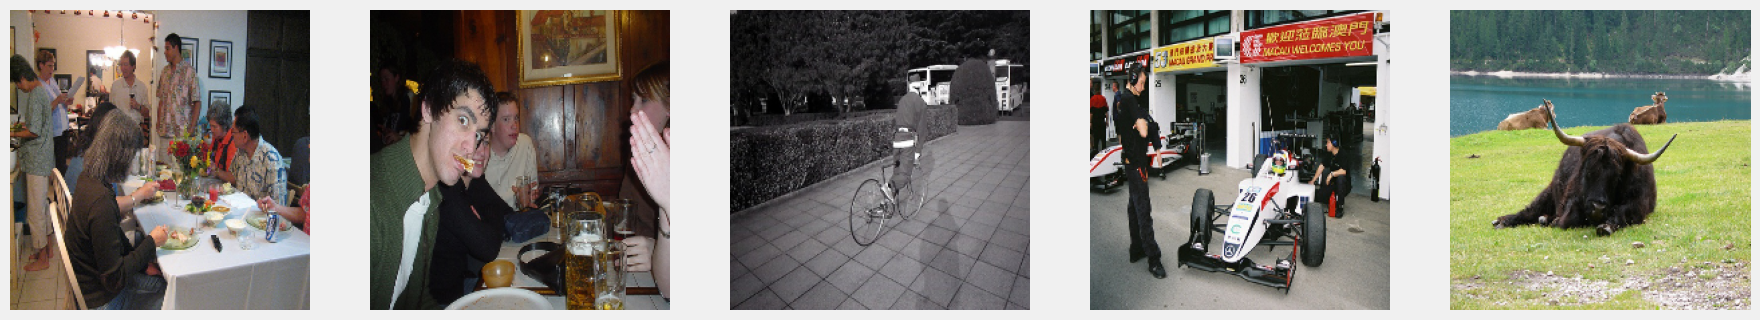

In [42]:
cls_num=5
num_images=5

anom_indices=(predict_1_df[predict_1_df.category==cls_num]).index.values[:50]
imgs=get_imgs(all_data,anom_indices)
anom_images=imgs[:num_images]
show_images(anom_images)

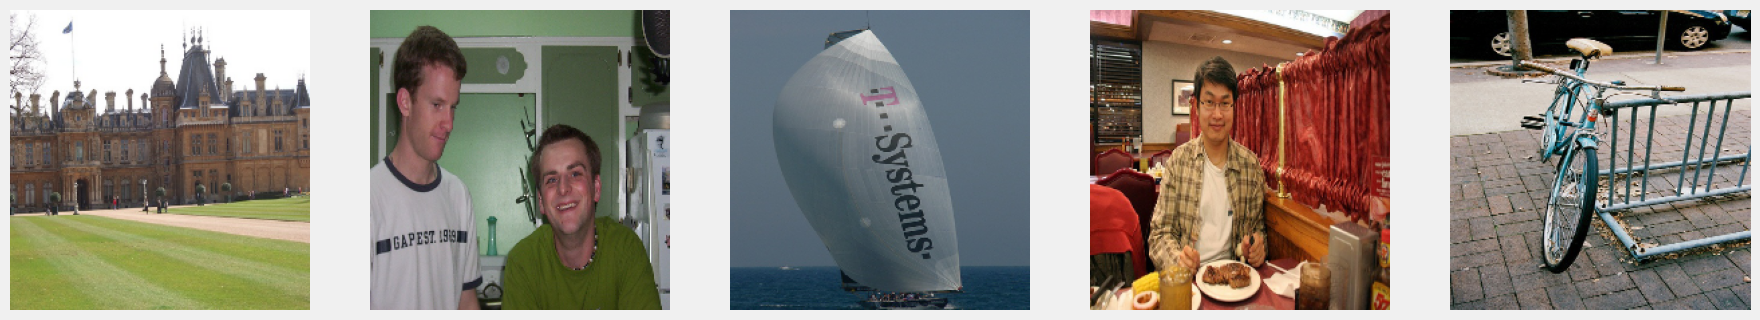

In [43]:
cls_num=8
num_images=5

anom_indices=(predict_1_df[predict_1_df.category==cls_num]).index.values[:50]
imgs=get_imgs(all_data,anom_indices)
anom_images=imgs[:num_images]
show_images(anom_images)

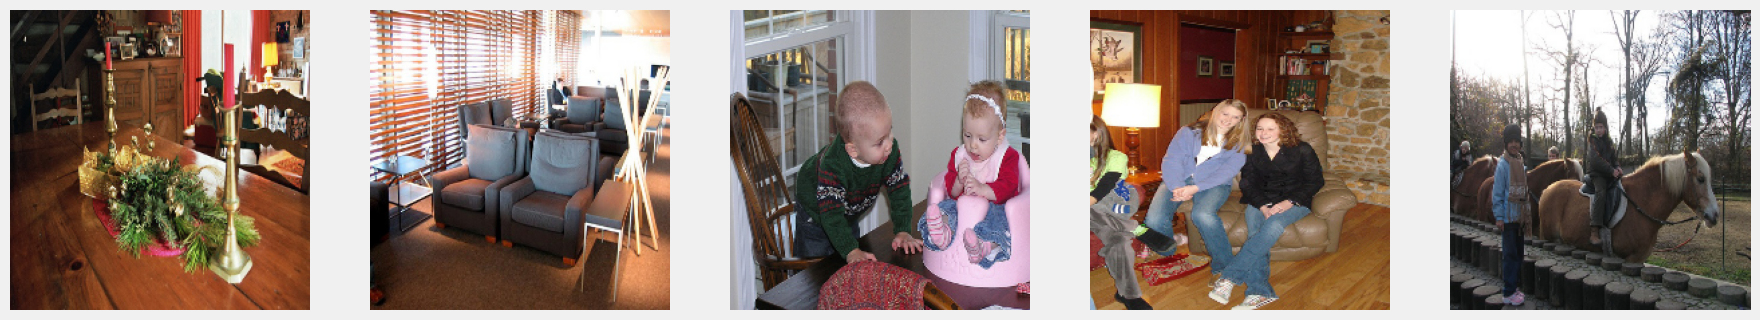

In [44]:
cls_num=14
num_images=5

anom_indices=(predict_1_df[predict_1_df.category==cls_num]).index.values[:50]
imgs=get_imgs(all_data,anom_indices)
anom_images=imgs[:num_images]
show_images(anom_images)

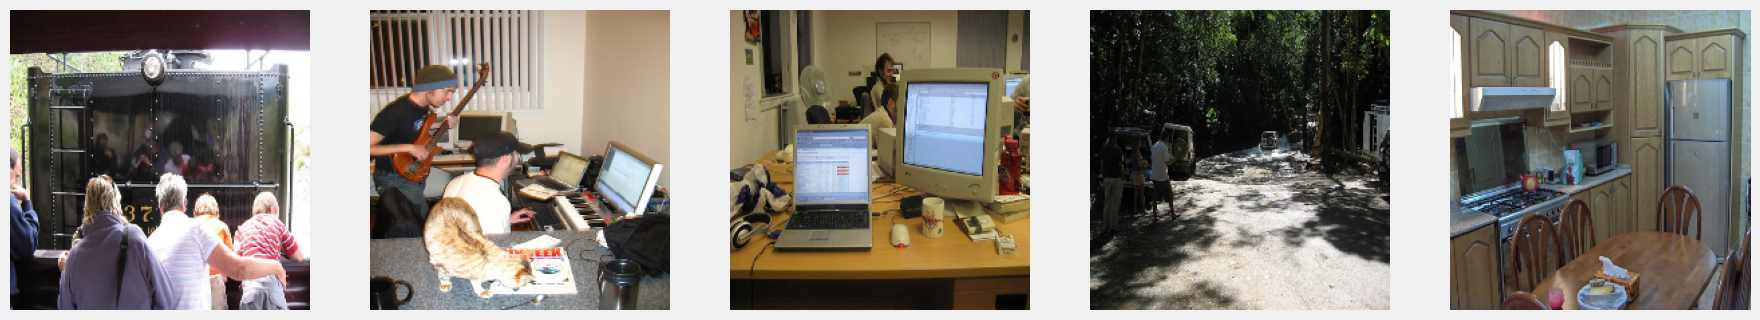

In [45]:
cls_num=18
num_images=5

anom_indices=(predict_1_df[predict_1_df.category==cls_num]).index.values[:50]
imgs=get_imgs(all_data,anom_indices)
anom_images=imgs[:num_images]
show_images(anom_images)